Используется датасет https://www.kaggle.com/uciml/german-credit

Для запуска блокнота, скачайте датасет и поместите его в директорию data.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from numpy import arange

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from umap import UMAP

from seaborn import boxplot

raw_data = pd.read_csv('data/german_credit_data.csv')

# EDA

Выводим на экран несколько строк таблицы что бы получить примерное представление о данных.

In [28]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
raw_data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


Получаем список признаков, содержащих строковые данные. Если датасет был плохо подготовлен, то он может содержать числовые значения в виде строк (например, '3.14' вместо 3.14). Наша задача - обнаружить колонки, содержащие такие значения.

In [29]:
raw_data.select_dtypes(include=['object']).head()

,Sex,Housing,Saving accounts,Checking account,Purpose
0,male,own,NaN,little,radio/TV
1,female,own,little,moderate,radio/TV
2,male,own,little,NaN,education
3,male,free,little,little,furniture/equipment
4,male,free,little,little,car


Удалим колонку "unnamed" потому что она бесполезна.
Приведем все строки к нижнему регистру.
Заменим пустые строки на NaN.

In [30]:
# удаляем колонку 'unnamed'
raw_data = raw_data.drop(raw_data.columns[[0]], axis=1)

# приводим все строки к одному регистру
categorial_data = raw_data.select_dtypes(include=['object'])
for column in categorial_data.columns:
    raw_data[column] = raw_data[column].apply(lambda x: x.lower() if isinstance(x, str) else x)

#заменяем пустые строки на NaN
raw_data = raw_data.replace(r'^\s*$', np.nan, regex=True)

Есть ли записи, содержащие значения NaN или пустые строки?

In [31]:
s = raw_data.isna().sum()
s[s > 0]

Saving accounts     183
Checking account    394
dtype: int64

Записей, содержащих NaN очень много, поэтому мы не можем их удалить.

Кодируем категориальные признаки. NaN будет закодирован отдельным значением.

In [32]:
categorial_data = raw_data.select_dtypes(include=['object'])
processed_data = raw_data.copy()
for column in categorial_data.columns:
    processed_data[column] = LabelEncoder().fit_transform(raw_data[column])

processed_data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5
2,49,1,1,1,0,3,2096,12,3
3,45,1,2,0,0,0,7882,42,4
4,53,1,2,0,0,0,4870,24,1


Приводим все значения к одному маштабу. Причина: k-means вычисляет евклидово расстояние. Если, к примеру, значение одного признака лежит в диапазоне [10, 10000], а другого - в [0.1, 0.5], то первый признак будет вносить больший вклад чем второй.

In [33]:
scaled_values = MinMaxScaler((0, 1)).fit_transform(processed_data.values)
processed_data = pd.DataFrame(scaled_values, columns=processed_data.columns)
processed_data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0.857143,1.0,0.666667,0.5,1.0,0.000000,0.050567,0.029412,0.714286
1,0.053571,0.0,0.666667,0.5,0.0,0.333333,0.313690,0.647059,0.714286
2,0.535714,1.0,0.333333,0.5,0.0,1.000000,0.101574,0.117647,0.428571
3,0.464286,1.0,0.666667,0.0,0.0,0.000000,0.419941,0.558824,0.571429
4,0.607143,1.0,0.666667,0.0,0.0,0.000000,0.254209,0.294118,0.142857


# Кластеризация

# Утилиты

Определим функции, которые пригодятся нам в дальнейшем.

In [34]:
def show_clusters(data: pd.DataFrame, labels: list):
    '''
    Отображает кластера на экране используя разные методы понжения размерности: PCA, UMAP, TSNE.
    '''

    print('--- PCA ---')
    X = PCA(n_components=2, random_state=123).fit_transform(data)
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.nipy_spectral)
    plt.show()

    print('--- UMAP ---')
    X = UMAP(n_components=2, random_state=123, n_jobs=1).fit_transform(data)
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.nipy_spectral)
    plt.show()

    print('--- TSNE ---')
    X = TSNE(n_components=2, random_state=123).fit_transform(data)
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.nipy_spectral)
    plt.show()


def print_means(raw_data: pd.DataFrame, labels: list):
    '''
    Выводит на экран средние значения числовых признаков для каждого кластера.
    '''

    unique_cluster_indicies = sorted(set(labels))

    for cluster_index in unique_cluster_indicies:
        cluster = raw_data.loc[lambda df: labels[df.index] == cluster_index]
        mean_age = cluster['Age'].mean()
        mean_credit_amount = cluster['Credit amount'].mean()
        mean_duration = cluster['Duration'].mean()

        print(f'= Cluster #{cluster_index} =')
        print(f'Age: {mean_age}')
        print(f'Credit amount: {mean_credit_amount}')
        print(f'Duration: {mean_duration}')
        print()


def show_boxplots(raw_data: pd.DataFrame, labels: list):
    '''
    Строит ящики с усами для всех признаков.
    '''

    clustered_raw_data = raw_data.copy()
    clustered_raw_data['Label'] = labels

    for feautre in raw_data.columns:
        boxplot(clustered_raw_data, y=feautre, hue='Label', medianprops={'color': 'r', 'ls': ':', 'lw': 5}, palette='Set1')
        plt.show()

# K-Means

Подбираем количество кластеров при помощи Elbow method.

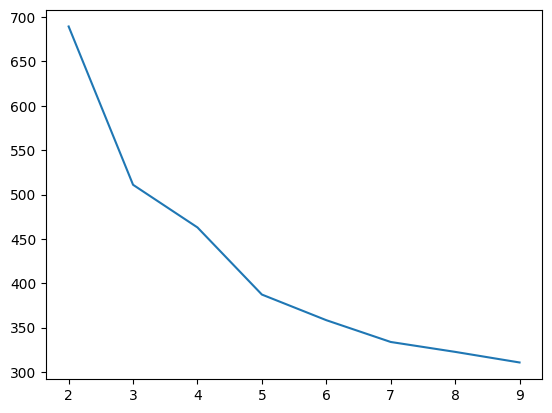

In [35]:
n_clusters_list = []
inertia_list = []
for n_clusters in range(2, 10):
    k_means = KMeans(n_clusters=n_clusters, random_state=123)
    k_means.fit(processed_data.values)
    inertia = k_means.inertia_
    n_clusters_list.append(n_clusters)
    inertia_list.append(inertia)

plt.plot(n_clusters_list, inertia_list)
plt.show()

Количество кластеров лежит в диапазоне [3..8]. Попробуем построить Silhouette plot.

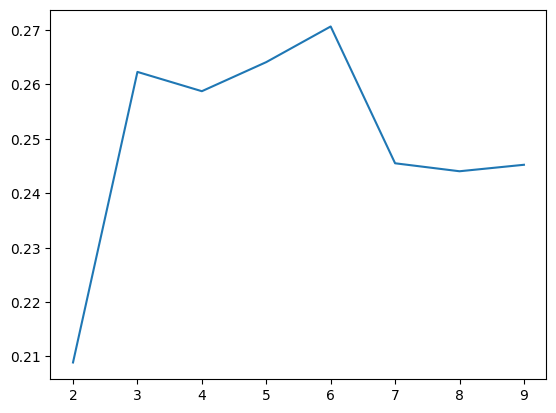

In [36]:
n_clusters_list = []
score_list = []
for n_clusters in range(2, 10):
    k_means = KMeans(n_clusters=n_clusters, random_state=123)
    labels = k_means.fit_predict(processed_data.values)

    score = silhouette_score(processed_data.values, labels)

    n_clusters_list.append(n_clusters)
    score_list.append(score)

plt.plot(n_clusters_list, score_list)
plt.show()

Согласно графику, оптимальное количество кластеров - шесть. Однако мы попробуем два значения: два и шесть. Визуализируем результат при помощи PCA, UMAP и TSNE.

=== 2 clusters ===
--- PCA ---


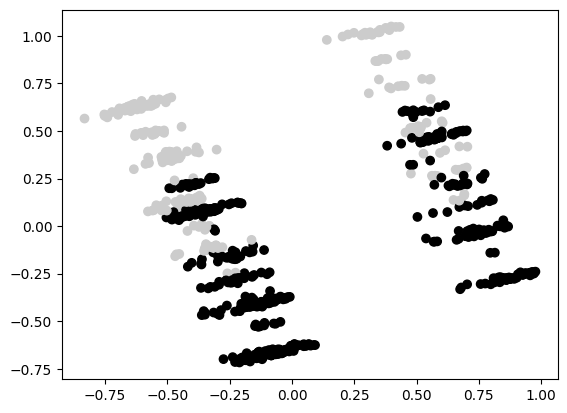

--- UMAP ---


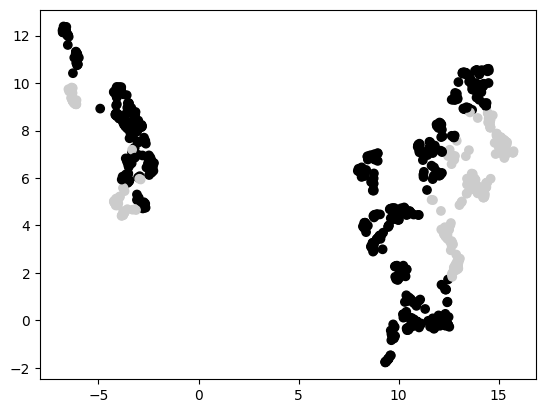

--- TSNE ---


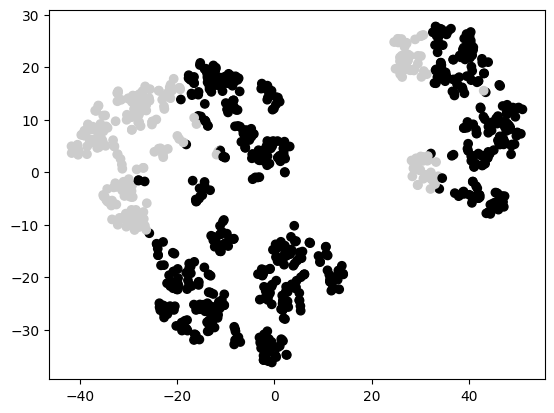

=== 6 clusters ===
--- PCA ---


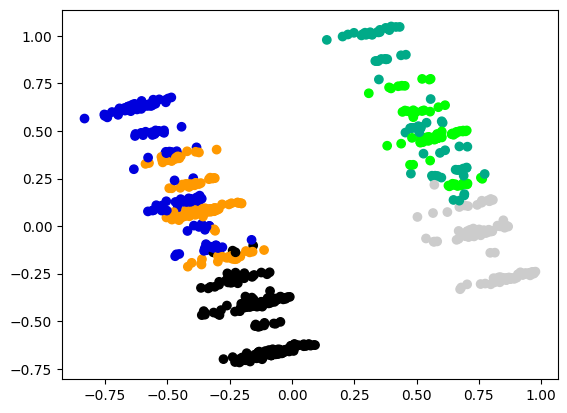

--- UMAP ---


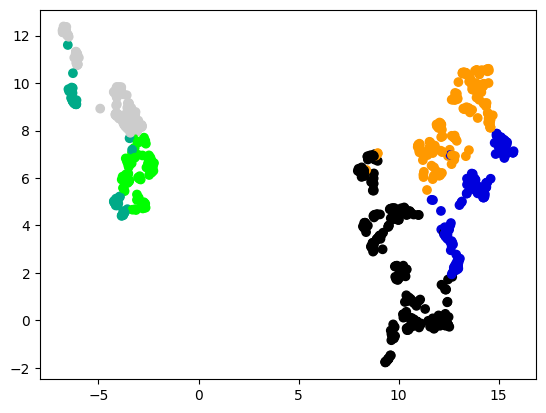

--- TSNE ---


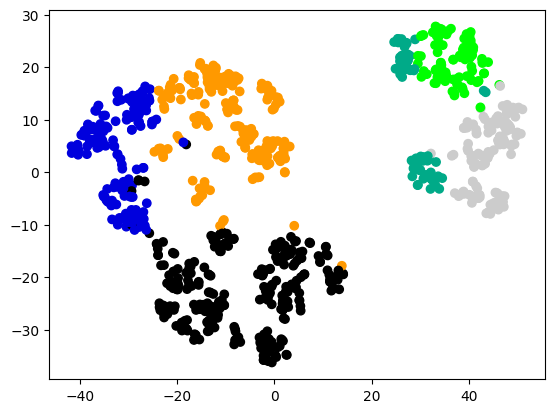

In [37]:
for n_clusters in [2, 6]:
    labels = KMeans(n_clusters=n_clusters, random_state=123).fit_predict(processed_data.values)

    print(f'=== {n_clusters} clusters ===')
    show_clusters(processed_data.values, labels)

2 кластера - хотя кластера хорошо видны на изображениях, k-means не сумел разделить данные. Видимо, причина в том, что кластеры представляют собой невыпуклые множества.

6 кластеров - трудно понять, где заканчивается один кластер, а где начинается другой. Более-менее понятная картина только при визуализации при помощи TSNE.

# AgglomerativeClustering

Подберем число кластеров при помощи Silhouette plot.

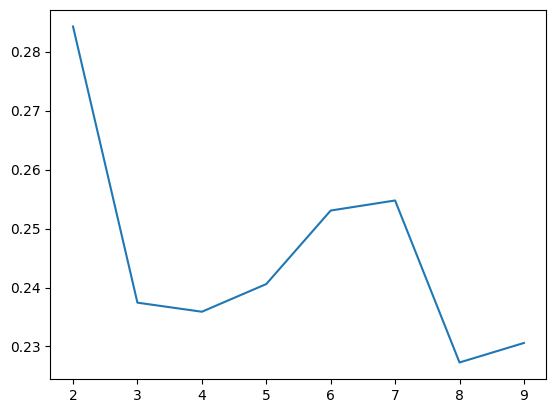

In [38]:
score_list = []
rng = range(2, 10)
for n_clusters in rng:
    labels = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(processed_data.values)

    score = silhouette_score(processed_data.values, labels)
    score_list.append(score)

plt.plot(rng, score_list)
plt.show()

Оптимальное число кластеров - два. Но мы попробуем также шесть кластеров, что бы сравнить реузльтат кластеризации с k-means.

=== 2 clusters ===
--- PCA ---


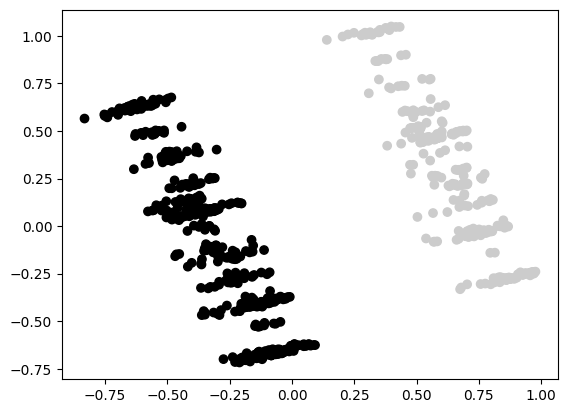

--- UMAP ---


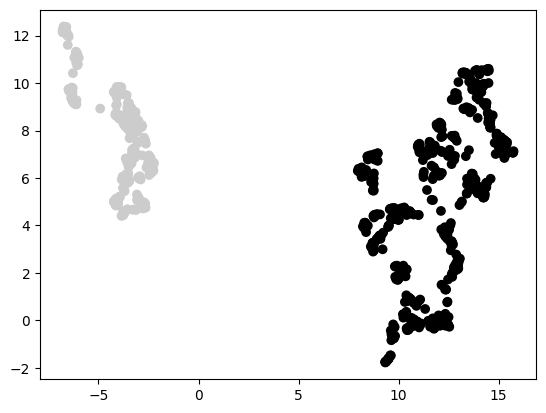

--- TSNE ---


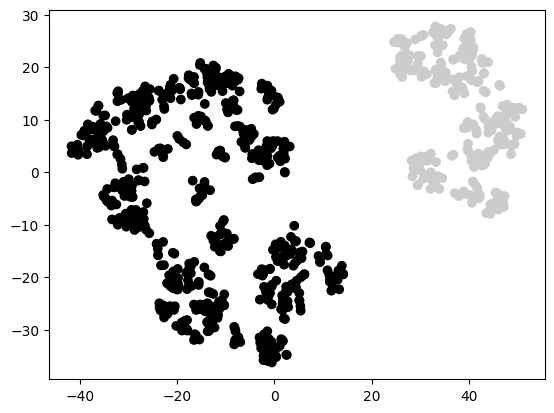

=== 6 clusters ===
--- PCA ---


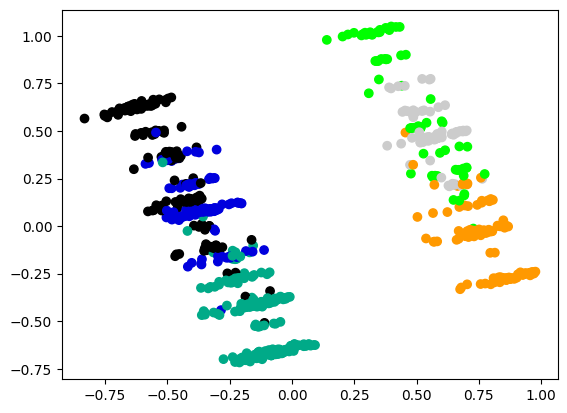

--- UMAP ---


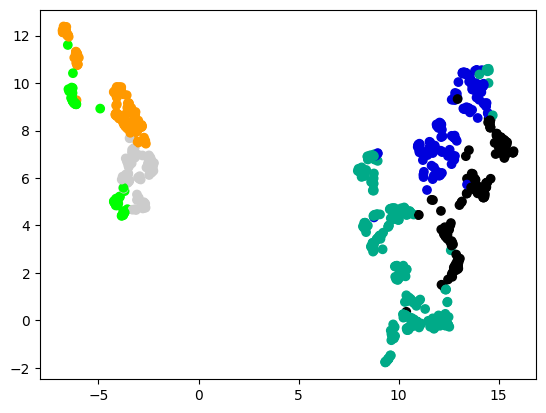

--- TSNE ---


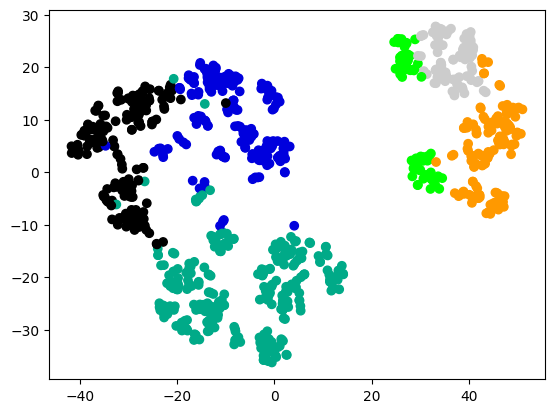

In [39]:
for n_clusters in [2, 6]:
    labels = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(processed_data.values)

    print(f'=== {n_clusters} clusters ===')
    show_clusters(processed_data.values, labels)

Иерархический кластеризатор хорошо поделил данные на два кластера. Результат деления на семь кластеров не лучше чем у k-means.

# DBSCAN

Подберем эпсилон силуэтным методом. Min_samples оставим по-умолчанию т.к. этот параметр имеет смысл менять для борьбы с шумом.

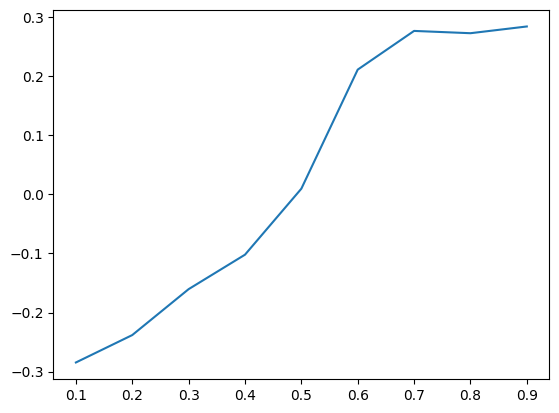

In [40]:
rng = arange(0.1, 1.0, 0.1)
score_list = []
for epsilon in rng:
    labels = DBSCAN(eps=epsilon, min_samples=5).fit_predict(processed_data.values)

    score = silhouette_score(processed_data.values, labels)
    score_list.append(score)

plt.plot(rng, score_list)
plt.show()

--- PCA ---


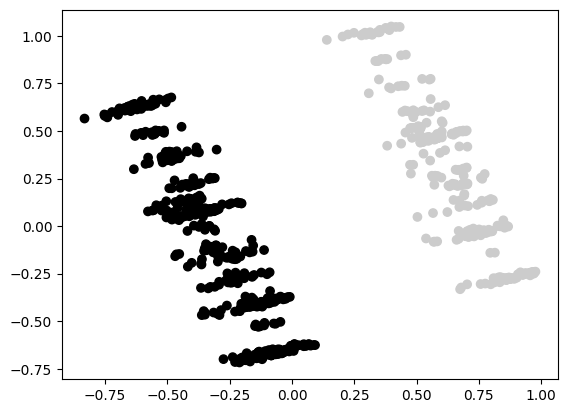

--- UMAP ---


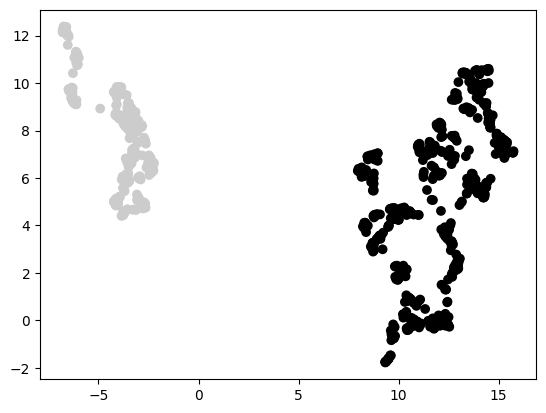

--- TSNE ---


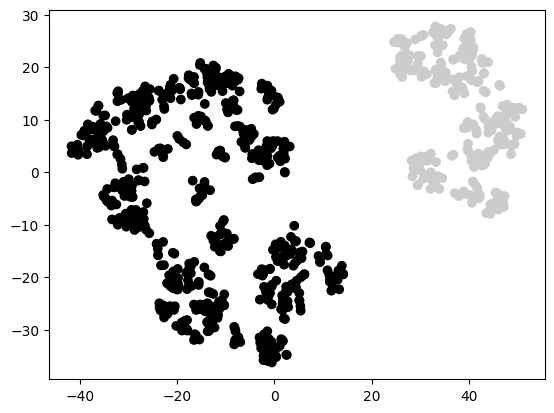

In [41]:
labels = DBSCAN(eps=0.9, min_samples=5).fit_predict(processed_data.values)

show_clusters(processed_data.values, labels)

DBSCAN уверенно делит данные на два кластера. Результат не отличается от AgglomerativeClustering.

# Интерпретация

Попробуем интерпретировать вариант с двумя кластерами. Стоило бы рассмотреть и вариант с шестью кластерами, однако мы этого делать не будем. Вместо этого позже мы рассмотрим другой вариант кластеризации.<br/><br/>
Сперва найдем средние значения для числовых признаков.

In [42]:
labels = DBSCAN(eps=0.9, min_samples=5).fit_predict(processed_data.values)
print_means(raw_data, labels)

= Cluster #0 =
Age: 36.778260869565216
Credit amount: 3448.040579710145
Duration: 21.56086956521739

= Cluster #1 =
Age: 32.803225806451614
Credit amount: 2877.7741935483873
Duration: 19.438709677419354



Люди в кластере 0 несколько старше, берут кредиты на большие суммы и на больший срок. Теперь построим ящики с усами. Красной пунктирной линией обозначена медиана.

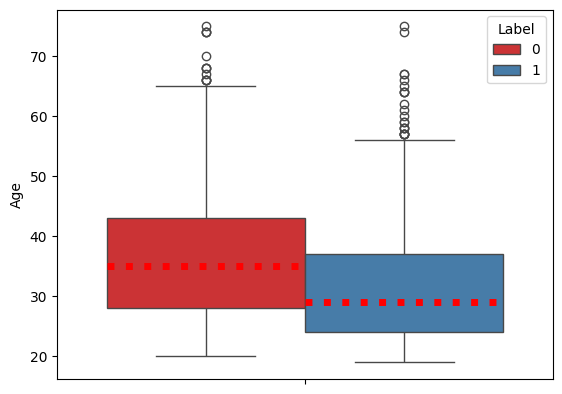

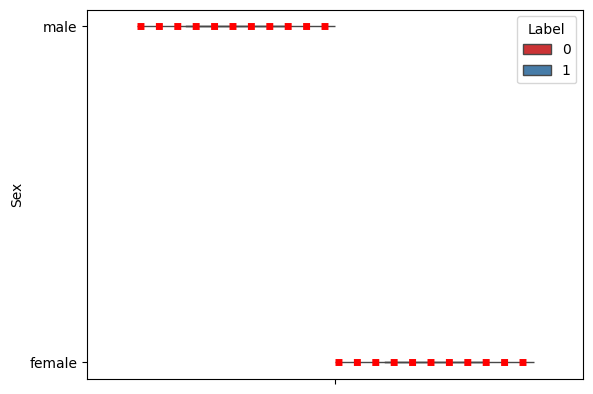

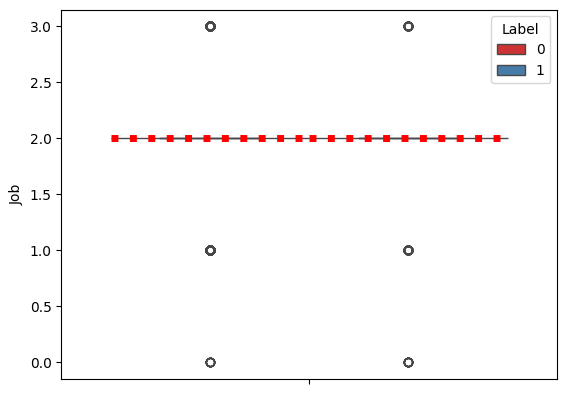

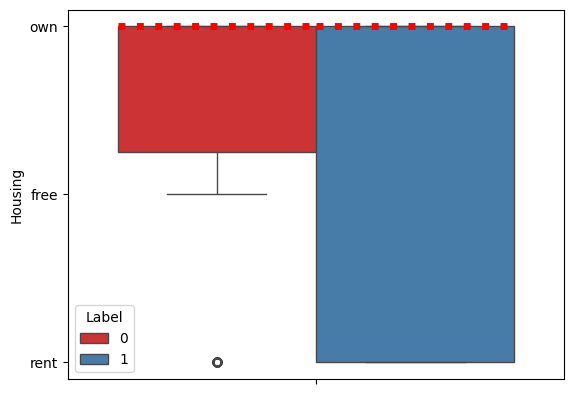

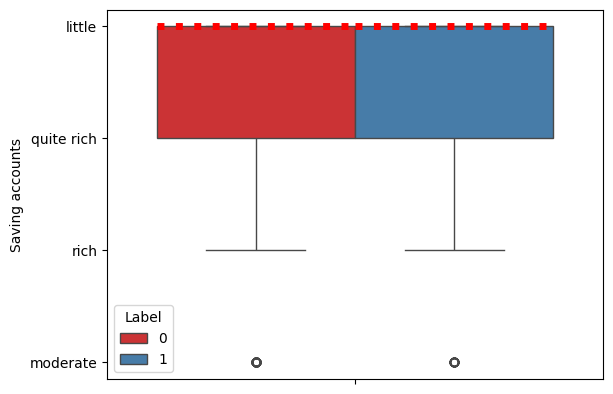

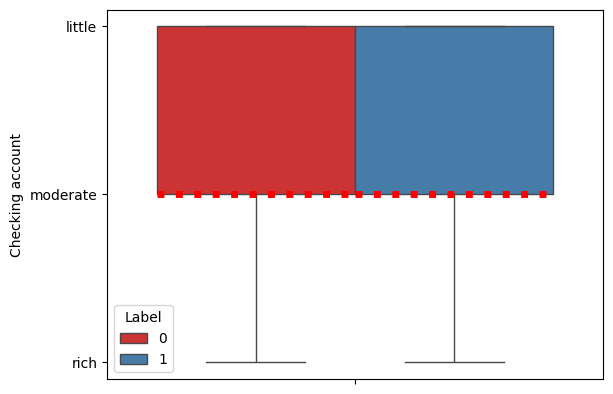

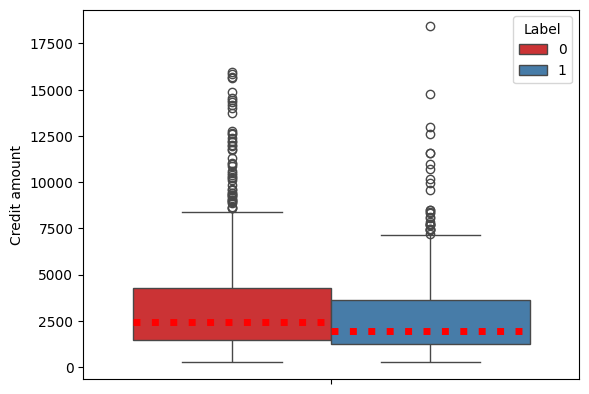

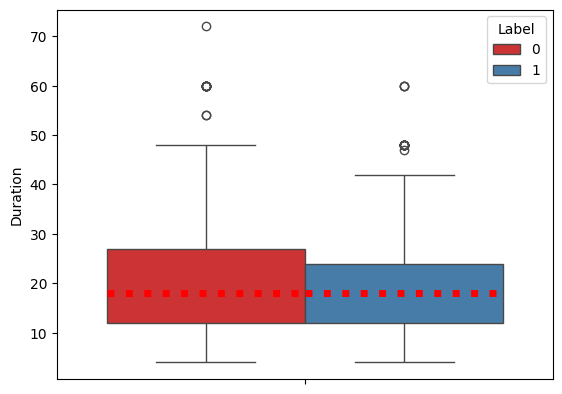

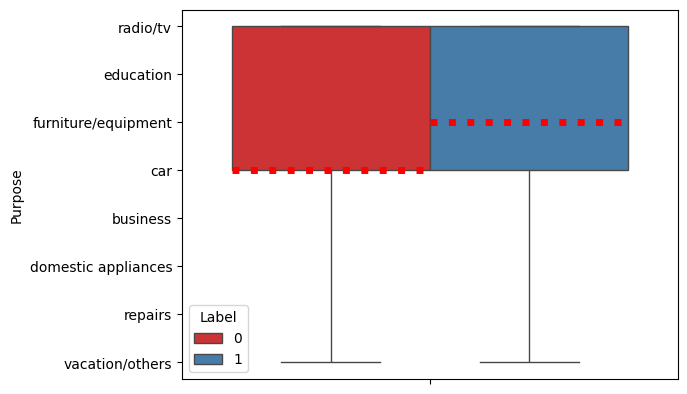

In [43]:
show_boxplots(raw_data, labels)

# Выводы
DBSCAN поделил всех клиентов банка на мужчин и женщин.

Между полами есть небольшие отличия:
- самое большое различие - женщины чаще чем мужчины живут на съемном жилье и намного чаще пользуются социальным жильем;
- женщины берут кредит на меньшие суммы и на меньший срок;
- мужчины чаще берут кредиты на машину, а женщины - на покупку мебели;
- клиенты женского пола моложе чем мужчины.

# Кластеризация без колонки "Sex"

Колонка "Sex" вносит слишком сильный вклад в кластеризацию. При этом клиенты обоих полов не так уж сильно отличаются друг от друга. Попробуем выполнить кластеризацию без учета пола.

In [44]:
processed_data = processed_data.drop(['Sex'], axis=1)

# K-Means

Найдем число кластеров при помощи Silhouette plot.

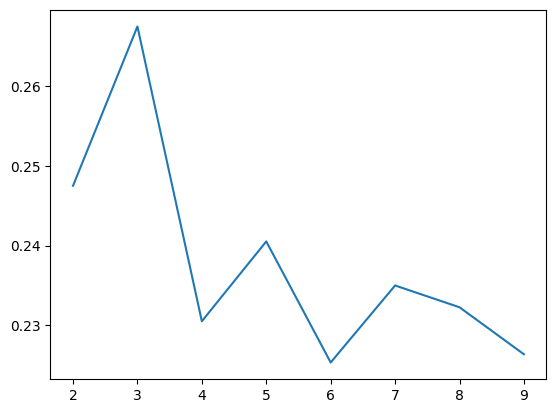

In [45]:
score_list = []
rng = range(2, 10)
for n_clusters in rng:
    labels = KMeans(n_clusters=n_clusters, random_state=123).fit_predict(processed_data.values)

    score = silhouette_score(processed_data.values, labels)
    score_list.append(score)

plt.plot(rng, score_list)
plt.show()

Оптимальное число кластеров - три.

--- PCA ---


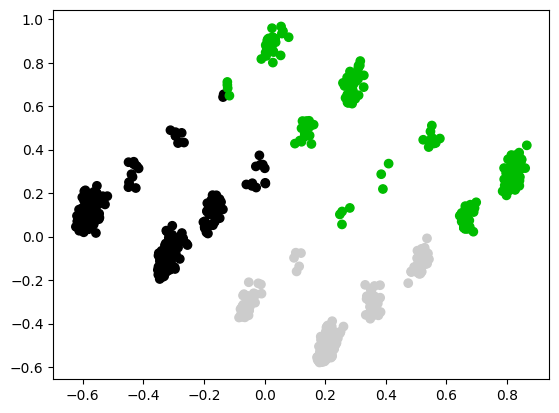

--- UMAP ---


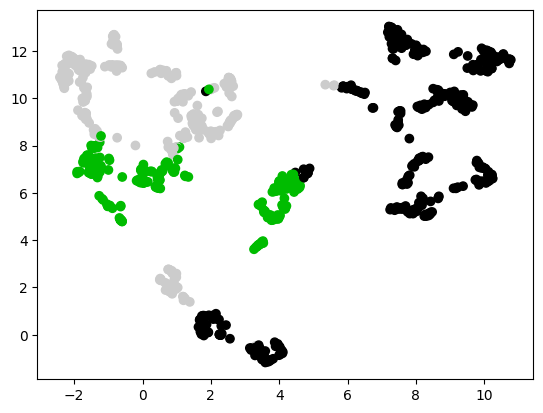

--- TSNE ---


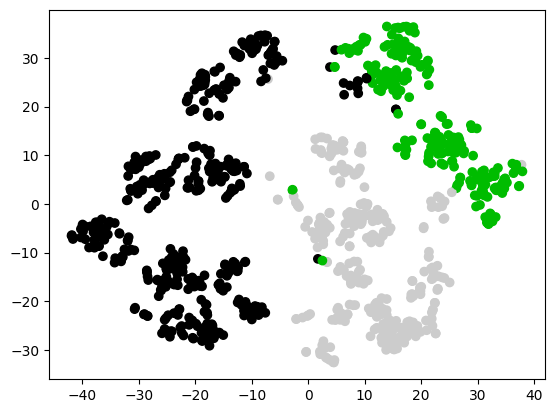

In [46]:
labels = KMeans(n_clusters=3, random_state=123).fit_predict(processed_data.values)

show_clusters(processed_data.values, labels)

# AgglomerativeClustering

Найдем число кластеров.

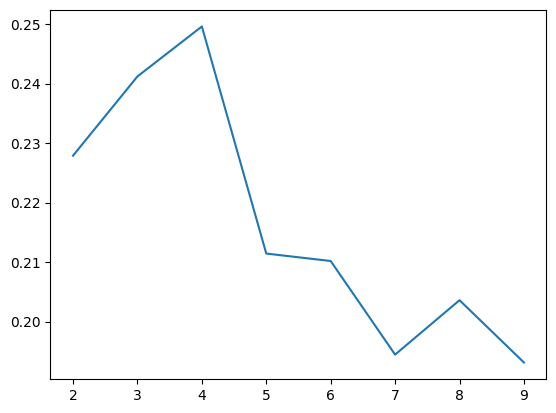

In [47]:
score_list = []
rng = range(2, 10)
for n_clusters in rng:
    labels = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(processed_data.values)

    score = silhouette_score(processed_data.values, labels)
    score_list.append(score)

plt.plot(rng, score_list)
plt.show()

Silhouette plot выделил четыре кластера. Проведем кластеризацию и визуализируем результат.

--- PCA ---


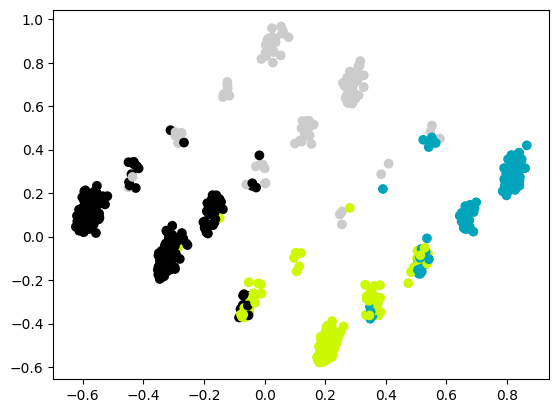

--- UMAP ---


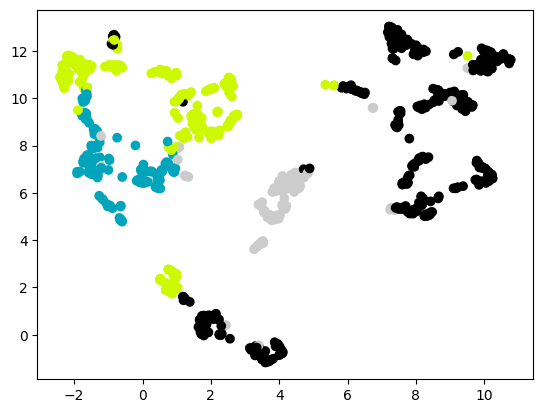

--- TSNE ---


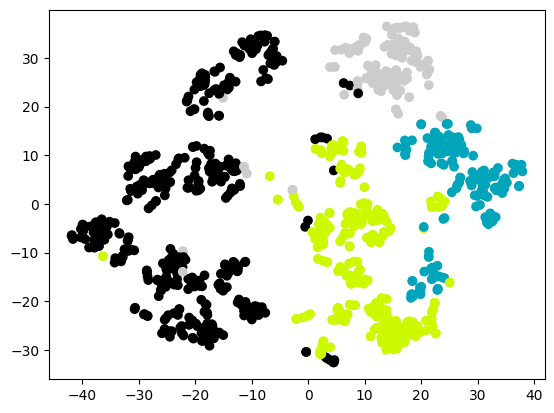

In [48]:
labels = AgglomerativeClustering(n_clusters=4).fit_predict(processed_data.values)

show_clusters(processed_data.values, labels)

На изображении, полученном при помощи PCA можно с натяжкой выделить четыре кластера. На изображении, полученном при помощи UMAP, трудно что-либо разобрать. На изображении, полученном при помощи tSNE, можно выделить около 6-и кластеров. В целом, результаты кластеризации неудовлетворительны.

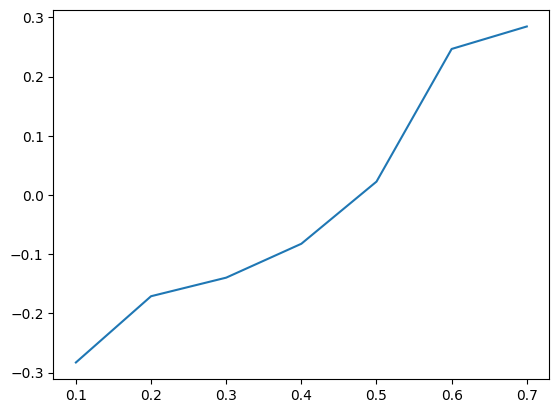

In [49]:
score_list = []
rng = arange(0.1, 1.0, 0.1)
eps_values = []
for eps in rng:
    clustering = DBSCAN(eps=eps, min_samples=5)
    labels = clustering.fit_predict(processed_data.values)

    if len(set(labels)) >= 2:
        eps_values.append(eps)
        score = silhouette_score(processed_data.values, labels)
        score_list.append(score)

plt.plot(eps_values, score_list)
plt.show()

--- PCA ---


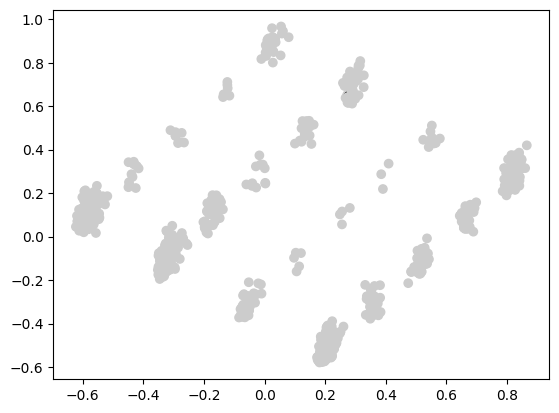

--- UMAP ---


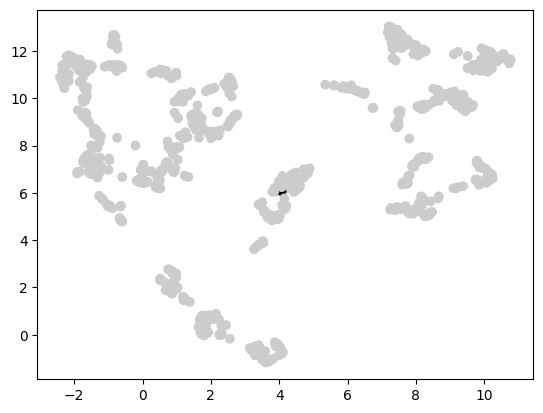

--- TSNE ---


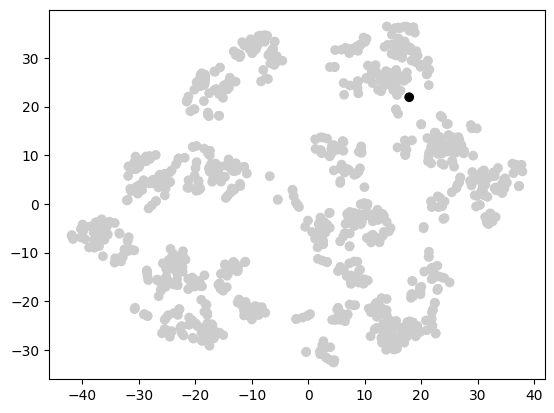

In [50]:
labels = DBSCAN(eps=0.7, min_samples=5).fit_predict(processed_data.values)

show_clusters(processed_data.values, labels)

DBSCAN совершенно не справился с задачей, поместив почти все данные в один кластер.

# Интерпретация результатов

Мы будем пользоватся результатами иерархической кластеризации т.к. она дала лучший результат.<br/><br/>
Найдем средние.

In [51]:
labels = AgglomerativeClustering(n_clusters=4).fit_predict(processed_data.values)

print_means(raw_data, labels)

= Cluster #0 =
Age: 34.3162583518931
Credit amount: 3453.4832962138084
Duration: 22.024498886414253

= Cluster #1 =
Age: 38.451219512195124
Credit amount: 3450.140243902439
Duration: 21.51219512195122

= Cluster #2 =
Age: 35.92936802973978
Credit amount: 2781.9144981412637
Duration: 18.576208178438662

= Cluster #3 =
Age: 35.313559322033896
Credit amount: 3444.7966101694915
Duration: 21.093220338983052



Кластера не слишком сильно отличаются друг от друга, однако можно выделить №1 и №2.
Клиенты в кластере №1 в среднем старше.
Клиенты в кластере №2 берут кредиты на меньшие суммы.

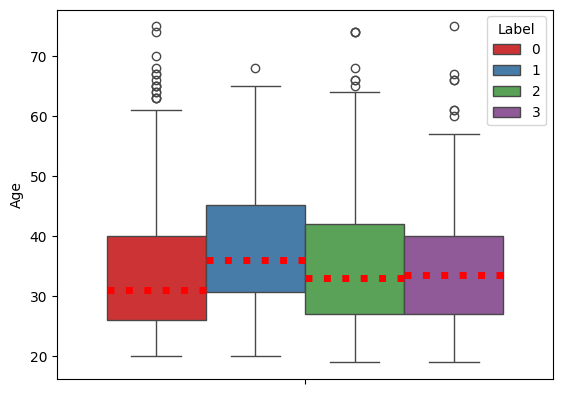

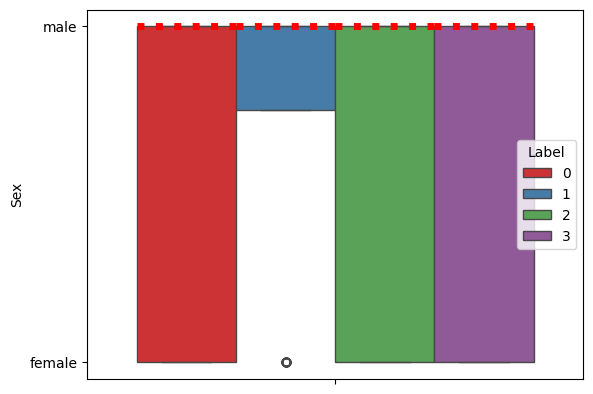

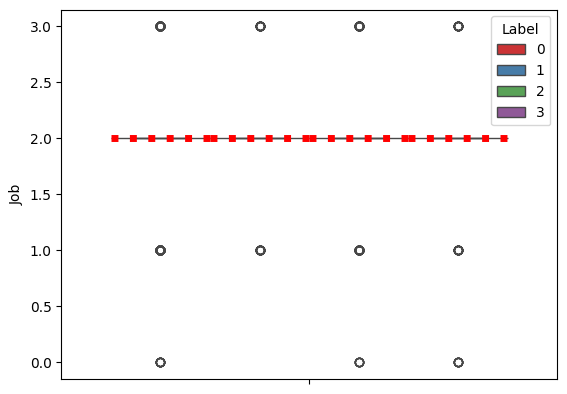

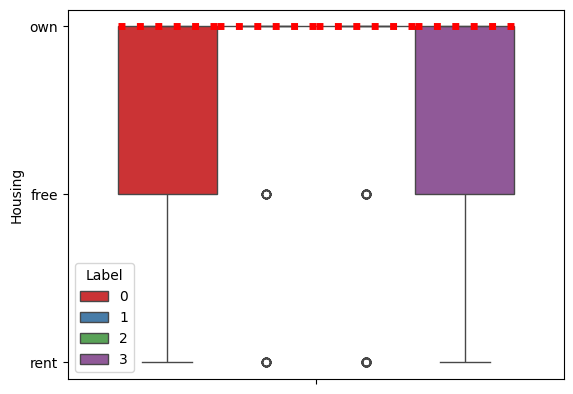

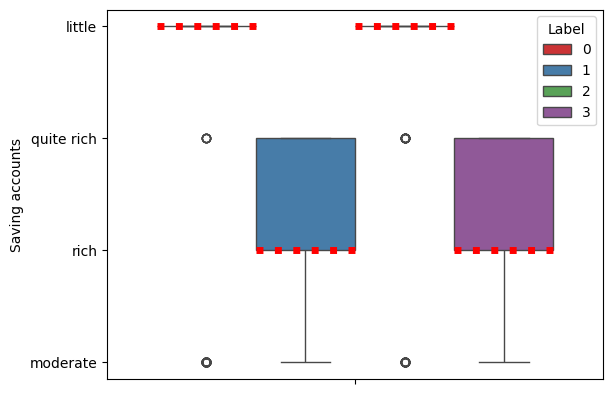

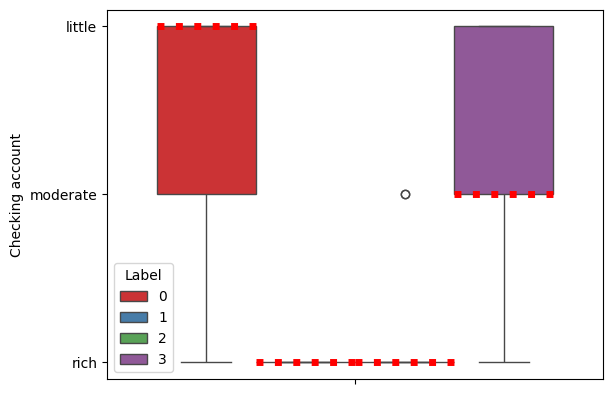

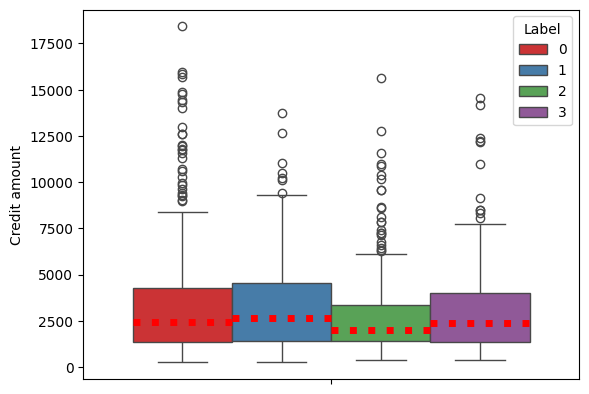

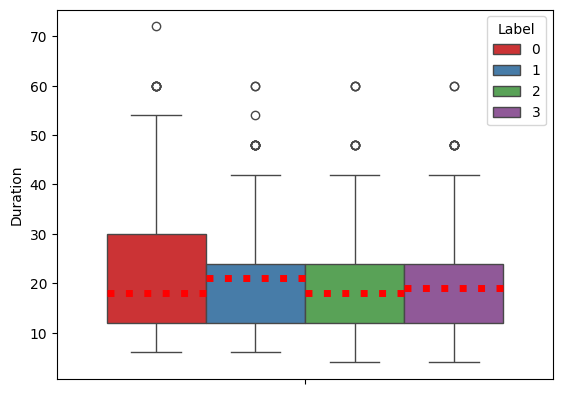

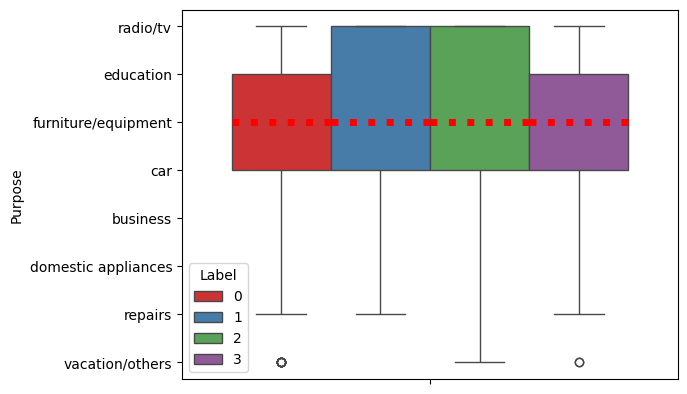

In [52]:
show_boxplots(raw_data, labels)

# Выводы

Интересен кластер №1 (кластера нумеруются от 0). В него входят почти исключительно состоятельные мужчины-домовладельцы, которые откладывают денги на старость/черный день (см. Saving account).

Также стоит обратить внимание на кластер №3. Эти люди достаточно обеспечены, однако не держат сберегательного счета и берут кредит под отпуск (пускай и не часто).

# Дальнейшее исследование

На изображениях, полученных при помощи TSNE, можно было уверенно выделить 7-8 кластеров. Возможно, стоило бы попробовать СНАЧАЛА применить метод понижения размерности к данным, а затем произвести кластеризацию. Однако в рамках данной работы мы этого делать не будем.